---
#### FID implementation
---

In [1]:
import os
import random
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
# Load Pretrained InceptionV3 Model
def load_inception_model():
    inception    = models.inception_v3(pretrained=True, transform_input=False)
    inception.fc = torch.nn.Identity()  # Remove the classification layer
    inception.eval()  # Set to evaluation mode
    return inception

In [3]:
# Preprocess Images
def preprocess_images(image_paths):
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 requires 299x299 images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images = [preprocess(Image.open(img).convert('RGB')) for img in image_paths]
    return torch.stack(images)

In [4]:
# Extract Features
def extract_features(model, images):
    with torch.no_grad():
        features = model(images)
    return features.numpy()

In [5]:
# Compute FID
def calculate_fid(real_features, generated_features):
    mu_r, sigma_r = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_g, sigma_g = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    diff = mu_r - mu_g
    covmean, _ = sqrtm(sigma_r @ sigma_g, disp=False)  # Matrix square root
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_r + sigma_g - 2 * covmean)
    return fid

In [6]:
# Display Images
def display_images(image_paths, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
# Path to the folder containing images
image_folder = r'D:\AI-DATASETS\Images\dogs-cats\test'

In [8]:
# List all image files in the folder
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('png', 'jpg', 'jpeg'))]


In [9]:
# Select n random images
n = 100
random_images = random.sample(all_images, n)
plot_images   = random.sample(all_images, 10)

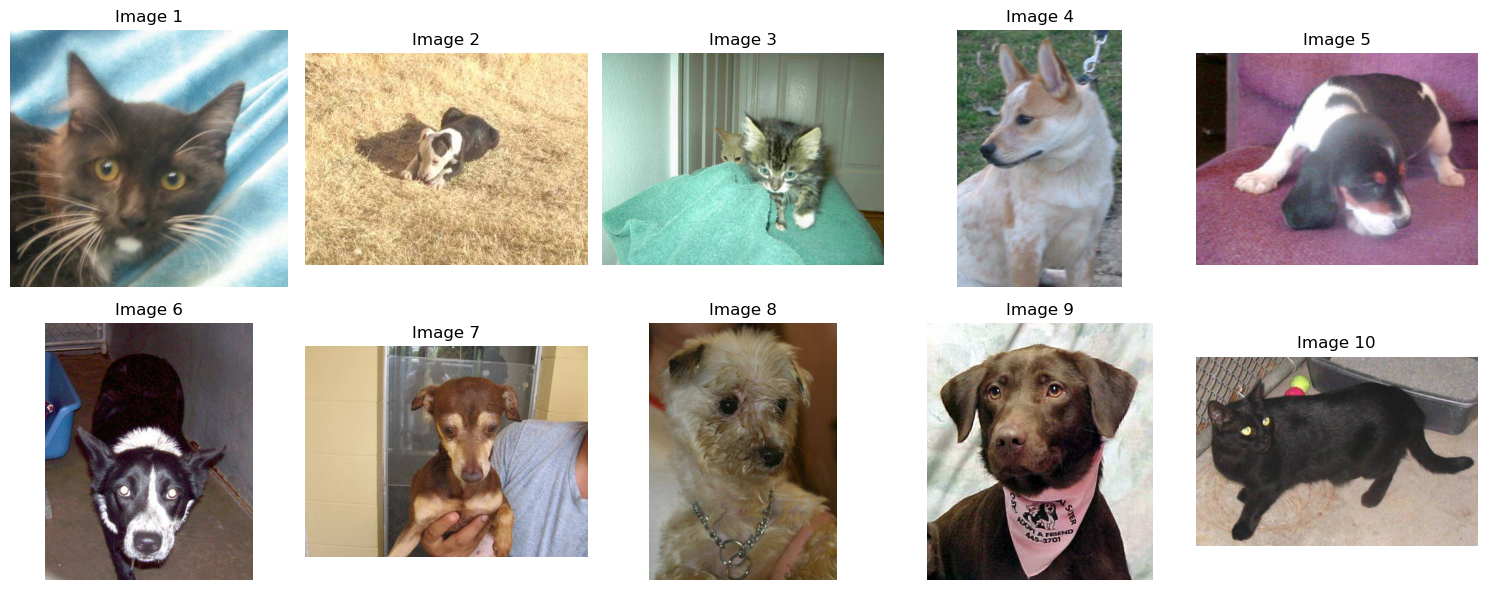

In [10]:
# Display the 10 random images
display_images(plot_images, rows=2, cols=5)

In [11]:
# Load InceptionV3 model
inception = load_inception_model()

D:\ANACONDA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Preprocess and extract features for random images
real_images      = preprocess_images(random_images[:50])  # Split first 50 for real
generated_images = preprocess_images(random_images[50:])  # Last 50 for generated

In [13]:
real_features      = extract_features(inception, real_images)
generated_features = extract_features(inception, generated_images)

In [14]:
# Calculate FID
fid_score = calculate_fid(real_features, generated_features)
print(f"FID Score: {fid_score}")

FID Score: 150.33088768614297


#### what Does FID Score 157.48 Mean?

**High Score:**
The score of **157.48** is relatively high, suggesting that the generated images and real images have significantly different feature distributions. This could mean:

- The generated images lack realism or diversity.
- The preprocessing or the dataset used for real and generated images may not align well.

---

**Possible Reasons for High FID:**

**1. Real vs. Generated Mismatch**
- The "real" and "generated" sets in this case are actually arbitrary splits of the same dataset. 
- If the generated images are not truly synthesized but are instead taken from the same dataset, the FID may not be meaningful.

**2. Quality of Images**
- If the images have noise, artifacts, or poor resolution, the features extracted by InceptionV3 may not represent their quality accurately.

**3. Number of Images**
- FID is sensitive to the number of images used. Using only 50 images for each set may not capture the full distribution, leading to higher variance in the score.

---

**Recommendations:**

**1. Increase the Sample Size**
- Use more images for both the real and generated sets (e.g., at least 1,000 images for each) to get a more robust FID score.

**2. Check Preprocessing**
- Ensure that the images are correctly preprocessed to match the requirements of InceptionV3.

**3. Use Truly Generated Images**
- Replace the "generated" set with actual outputs from a generative model, such as GANs or diffusion models.

**4. Inspect the Images**
- Visually inspect both real and generated image sets to identify any noticeable quality differences.
---

#### **When is FID Appropriate?**
FID is designed to compare:
1. **Real Images Distribution:** A dataset representing the real-world domain (e.g., natural images of cats and dogs).
2. **Generated Images Distribution:** A set of synthesized images generated by a model, aiming to mimic the real-world domain.

**Key Assumption:**  
The two distributions (real and generated) should ideally belong to the same domain.

---

#### **Are Cats and Dogs Images Suitable?**

1. **For Real Images:**
   - Using cats and dogs images as the **real images** is fine if they represent the real-world distribution you're trying to replicate.

2. **For Generated Images:**
   - If the **generated images** are also supposed to mimic cats and dogs, this dataset makes sense.  
   - For example:
     - Evaluating a GAN trained to generate realistic images of cats and dogs.

3. **If No True Generative Model is Used:**
   - If you arbitrarily split a single dataset (e.g., cats and dogs) into "real" and "generated" subsets, the FID score may lose significance because:
     - Both subsets come from the same distribution, which isn't the typical use case for FID.
     - The "generated" set isn’t actually synthesized by a model.

---

#### **Is FID Ideal for This Dataset?**

- **YES:**  
  - If you're training or evaluating a model to generate images of cats and dogs and want to measure how closely the generated images resemble the real ones.

- **NO:**  
  - If you're arbitrarily splitting the dataset and not actually working with generated images. In this case:
    - FID might still calculate a score but won’t provide meaningful insights about quality or diversity.
    - The score will primarily reflect noise or preprocessing differences between the two subsets.

---

#### **Recommendations**
- **For Generative Model Evaluation:**  
   - Use cats and dogs images if the generated images are designed to mimic this domain.
   - Ensure your generated images come from a model trained on this dataset.

- **For Arbitrary Dataset Splits:**  
   - FID isn’t the best metric if you’re just splitting and comparing within the same dataset. Consider metrics like:
     - Perceptual similarity (e.g., LPIPS).
     - Classification accuracy for domain classification tasks.

---


#### Example Implementation with MNIST dtataset

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow.keras.datasets import mnist
import torch

In [16]:
# Load MNIST dataset from Keras
def load_mnist_from_keras():
    (x_train, _), (x_test, _) = mnist.load_data()  # Only need the images, not labels
    return x_train, x_test

In [ ]:
# Load MNIST dataset from Keras
def load_mnist_from_keras():
    (x_train, _), (x_test, _) = mnist.load_data()  # Only need the images, not labels
    return x_train, x_test

In [17]:
# Updated preprocess_mnist function with batching
def preprocess_mnist_in_batches(images, batch_size=1000):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),  # Resize for InceptionV3
        transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    preprocessed_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        processed_batch = [transform(image) for image in batch]
        preprocessed_images.append(torch.stack(processed_batch))
    
    return torch.cat(preprocessed_images, dim=0)  # Concatenate all batches


In [18]:
# Load data
x_train, x_test = load_mnist_from_keras()

In [19]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [21]:
# Preprocess data
real_images      = preprocess_mnist_in_batches(x_train[:1000])  # First 10,000 training samples
generated_images = preprocess_mnist_in_batches(x_test[:1000])   # First 10,000 test samples

In [22]:
# Load InceptionV3 model
inception = load_inception_model()

In [23]:
# Extract features
# takes about 10-15 mins
real_features      = extract_features(inception, real_images)
generated_features = extract_features(inception, generated_images)

In [24]:
# Compute FID
fid_score = calculate_fid(real_features, generated_features)
print(f"FID Score: {fid_score}")

FID Score: 16.110770648439573


#### Thresholds for FID:

- 0–10: Excellent similarity; distributions are nearly identical.
- 10–50: Good similarity; slight differences in feature distributions.
- 50+: Noticeable differences; the generated images deviate significantly from the real ones.

#### Contextualizing the Score for MNIST

- MNIST is a simple dataset of `handwritten digits`. `Variability in its images is limited`, which makes it easier for generated images to resemble real ones.
- FID of 16.11:
    - Indicates that the test set (generated) images are reasonably similar to the training set (real) images, though there are minor differences in their feature distributions.
    - Differences could stem from variations in digit styles or preprocessing inconsistencies.

#### Possible Reasons for the FID Value

**Data Variability**:  
The test set may have some variations in handwriting styles or digit shapes that aren't well represented in the training set.

**Preprocessing Effects**:  
Resizing MNIST images from \(28 \times 28\) to \(299 \times 299\) and normalizing for InceptionV3 may introduce small distortions or artifacts.

**Feature Extraction**:  
InceptionV3 is pretrained on natural images, not handwritten digits, so extracted features may not perfectly capture MNIST-specific characteristics.

---

#### Insights for Improvement

**Preprocessing Consistency**:  
Ensure identical preprocessing for both real and generated images (e.g., resizing, normalization).

**Model Adjustment**:  
Fine-tune InceptionV3 on MNIST or use a simpler feature extractor tailored for handwritten digits.

**Balanced Data**:  
Ensure a balanced representation of all digit classes in both real and generated datasets.